In [ ]:
!brew install libdlib-dev python3-dlib cmake

==> Downloading https://formulae.brew.sh/api/formula.jws.json
==> Downloading https://formulae.brew.sh/api/cask.jws.json
==> Searching for similarly named formulae and casks...
==> Formulae
python-build

To install python-build, run:
  brew install python-build


In [2]:
%pip install face_recognition

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import face_recognition
import pickle

base_dir = "faces"
known_encodings = []
known_labels = []

for person_name in os.listdir(base_dir):
    person_dir = os.path.join(base_dir, person_name)
    if not os.path.isdir(person_dir):
        continue

    for file in os.listdir(person_dir):
        if file.lower().endswith((".jpg", ".png", ".jpeg")):
            image_path = os.path.join(person_dir, file)
            image = face_recognition.load_image_file(image_path)
            encodings = face_recognition.face_encodings(image)

            if encodings:
                known_encodings.append(encodings[0])
                known_labels.append(person_name)
                print(f"Encoded {file} as {person_name}")

with open("encodings.pickle", "wb") as f:
    pickle.dump({"encodings": known_encodings, "labels": known_labels}, f)

print("All encodings saved.")


Encoded IMG_1339 2.jpeg as Raul
Encoded IMG_9492 2.jpeg as Raul
Encoded IMG_9580 2.jpeg as Raul
Encoded IMG_2603 2.jpeg as Raul
Encoded IMG_7090 2.jpeg as Raul
Encoded IMG_3689 2.jpeg as Raul
Encoded IMG_1970 2.jpeg as Raul
Encoded IMG_2284 2.jpeg as Raul
Encoded IMG_9582 2.jpeg as Raul
Encoded IMG_7423 2.jpeg as Raul
Encoded IMG_9490 2.jpeg as Raul
Encoded IMG_3359 2.jpeg as Raul
Encoded IMG_3475 2.jpeg as Raul
Encoded IMG_3290 2.jpeg as Raul
Encoded IMG_8214 2.jpeg as Raul
Encoded IMG_6161 2.jpeg as Raul
Encoded IMG_9598 2.jpeg as Raul
Encoded IMG_3555 2.jpeg as Raul
Encoded IMG_6283 2.jpeg as Raul
Encoded IMG_3547 2.jpeg as Raul
Encoded IMG_4598 2.jpeg as Raul
Encoded IMG_8814 2.jpeg as Raul
Encoded IMG_3635 2.jpeg as Raul
Encoded IMG_3603 2.jpeg as Raul
Encoded IMG_9685 2.jpeg as Raul
Encoded IMG_7624 2.jpeg as Raul
Encoded IMG_3637 2.jpeg as Raul
Encoded IMG_3288 2.jpeg as Raul
Encoded IMG_9541 2.jpeg as Raul
Encoded IMG_3713 2.jpeg as Raul
Encoded IMG_2579 2.jpeg as Raul
Encoded 

System Ready. Press the button to attempt access.
Button Pressed


2025-06-03 14:31:24.877 python[6402:10274710] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


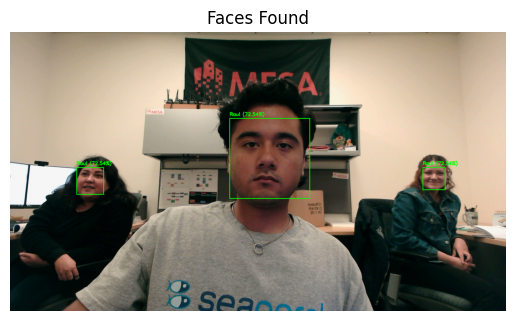

Access Granted
Ready for next attempt...
Button Pressed
No faces found.
Ready for next attempt...
Button Pressed


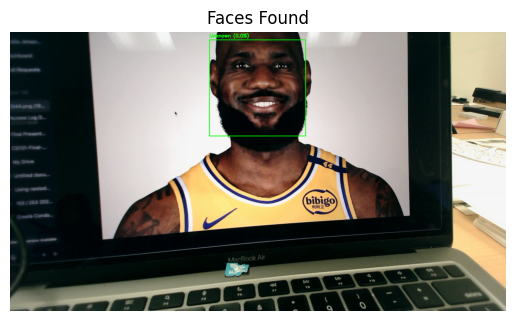

Access Denied
Ready for next attempt...
Button Pressed


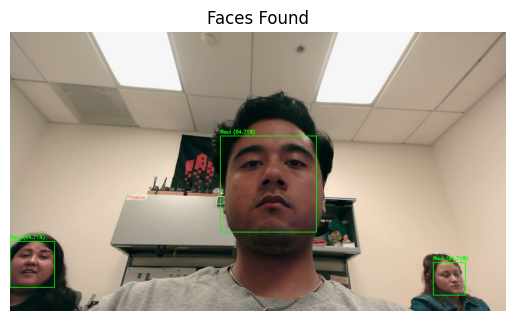

Access Granted
Ready for next attempt...
Exiting...


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/raulrazo/miniforge3/envs/cs131/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/Users/raulrazo/miniforge3/envs/cs131/lib/python3.10/site-packages/pyfirmata/util.py", line 54, in run
    while self.board.bytes_available():
  File "/Users/raulrazo/miniforge3/envs/cs131/lib/python3.10/site-packages/pyfirmata/pyfirmata.py", line 260, in bytes_available


    return self.sp.inWaiting()
  File "/Users/raulrazo/miniforge3/envs/cs131/lib/python3.10/site-packages/serial/serialutil.py", line 594, in inWaiting
    return self.in_waiting
  File "/Users/raulrazo/miniforge3/envs/cs131/lib/python3.10/site-packages/serial/serialposix.py", line 549, in in_waiting
    s = fcntl.ioctl(self.fd, TIOCINQ, TIOCM_zero_str)
TypeError: argument must be an int, or have a fileno() method.


In [1]:
import cv2
import pickle
import time
from datetime import datetime
from pyfirmata import Arduino, util
from matplotlib import pyplot as plt
import firebase_admin
from firebase_admin import credentials, db
import face_recognition
import numpy as np

# === Firebase setup ===
cred = credentials.Certificate("cs131-final-project-49b00-firebase-adminsdk-fbsvc-cfd4ddece0.json")
firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://cs131-final-project-49b00-default-rtdb.firebaseio.com/'
})

# === Arduino setup ===
DIGITAL_B = 11
DIGITAL_G = 12
DIGITAL_R = 7
SERVO_PIN = 5
BUTTON_PIN = 10
SERVO_OPEN = 90
SERVO_CLOSED = 30

board = Arduino('/dev/tty.usbmodem1101')
it = util.Iterator(board)
it.start()
time.sleep(1)

led_b = board.get_pin('d:{}:o'.format(DIGITAL_B))
led_g = board.get_pin('d:{}:o'.format(DIGITAL_G))
led_r = board.get_pin('d:{}:o'.format(DIGITAL_R))
servo = board.get_pin('d:{}:s'.format(SERVO_PIN))
button = board.get_pin('d:{}:i'.format(BUTTON_PIN))
button.enable_reporting()

def reset_system_state():
    led_b.write(1)
    led_g.write(0)
    led_r.write(0)
    servo.write(SERVO_CLOSED)
    time.sleep(1)

reset_system_state()

# === Load known face encodings ===
with open("encodings.pickle", "rb") as f:
    data = pickle.load(f)
    known_encodings = data["encodings"]
    known_labels = data["labels"]

# === Face Recognition Logic ===
def recognize_face():
    camera = cv2.VideoCapture(0)
    for _ in range(3):  # Warm-up
        ret, frame = camera.read()
        time.sleep(0.3)
    camera.release()

    if not ret:
        print("Failed to capture image.")
        return

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if rgb.dtype != np.uint8 or rgb.ndim != 3 or rgb.shape[2] != 3:
        print("Invalid image format.")
        return

    # Resize image for faster processing
    small_rgb = cv2.resize(rgb, (0, 0), fx=0.5, fy=0.5)
    face_locations = face_recognition.face_locations(small_rgb)

    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    ref = db.reference("access_logs")

    if len(face_locations) == 0:
        print("No faces found.")
        ref.push({
            "status": "no_face",
            "timestamp": timestamp,
            "confidence": 0.0,
            "faces_found": 0
        })
        led_b.write(0)
        for _ in range(7):
            led_r.write(1)
            time.sleep(0.5)
            led_r.write(0)
            time.sleep(0.5)
        reset_system_state()
        return

    try:
        face_encodings = face_recognition.face_encodings(small_rgb, face_locations)
    except TypeError as e:
        print("Failed to compute face encodings:", str(e))
        return

    name = "Unknown"
    confidence = 0.0
    best_match_index = None

    for encoding in face_encodings:
        matches = face_recognition.compare_faces(known_encodings, encoding, tolerance=0.5)
        face_distances = face_recognition.face_distance(known_encodings, encoding)

        if True in matches:
            best_match_index = np.argmin(face_distances)
            name = known_labels[best_match_index]
            confidence = (1.0 - face_distances[best_match_index]) * 100

    # Draw annotations
    for (top, right, bottom, left) in face_locations:
        top *= 2
        right *= 2
        bottom *= 2
        left *= 2
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
        label = f"{name} ({round(confidence, 2)}%)"
        cv2.putText(frame, label, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    cv2.imwrite("annotated_result.png", frame)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Faces Found")
    plt.show()

    if name != "Unknown":
        print("Access Granted")
        ref.push({
            "status": "granted",
            "timestamp": timestamp,
            "person": name,
            "confidence": round(confidence, 2),
            "faces_found": len(face_locations)
        })
        led_b.write(0)
        led_g.write(1)
        servo.write(SERVO_OPEN)
        time.sleep(7)
    else:
        print("Access Denied")
        ref.push({
            "status": "denied",
            "timestamp": timestamp,
            "confidence": round(confidence, 2),
            "faces_found": len(face_locations)
        })
        led_b.write(0)
        for _ in range(7):
            led_r.write(1)
            time.sleep(0.5)
            led_r.write(0)
            time.sleep(0.5)

    reset_system_state()

# === Main loop ===
print("System Ready. Press the button to attempt access.")

try:
    while True:
        if button.read() is True:
            print("Button Pressed")
            while button.read() is True:
                time.sleep(0.1)
            recognize_face()
            print("Ready for next attempt...")
        time.sleep(0.1)
except KeyboardInterrupt:
    print("Exiting...")
    board.exit()
